# Live de Python - Mercado Financeiro

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yfinance as yf
from functools import reduce
from itertools import product
from tqdm import tqdm

# Configurações

In [3]:
%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

# Principal

## Baixando dados via YFinance

In [4]:
yf.download?

Signature:
yf.download(
    tickers,
    start=None,
    end=None,
    actions=False,
    threads=True,
    group_by='column',
    auto_adjust=False,
    back_adjust=False,
    progress=True,
    period='max',
    show_errors=True,
    interval='1d',
    prepost=False,
    proxy=None,
    rounding=False,
    timeout=None,
    **kwargs,
)
Docstring:
Download yahoo tickers
:Parameters:
    tickers : str, list
        List of tickers to download
    period : str
        Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        Either Use period parameter or use start and end
    interval : str
        Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        Intraday data cannot extend last 60 days
    start: str
        Download start date string (YYYY-MM-DD) or _datetime.
        Default is 1900-01-01
    end: str
        Download end date string (YYYY-MM-DD) or _datetime.
        Default is now
    group_by : str
        Group by 'ticker' or 'column' (default)
    prep

In [5]:
ativo = 'ABEV3.SA'
data_inicio = '2000-01-01'
historico_dos_precos = yf.download(ativo, start=data_inicio)
# historico_dos_precos = pd.read_csv(ativo).set_index('Date')
# historico_dos_precos.index = pd.to_datetime(historico_dos_precos.index)

[*********************100%***********************]  1 of 1 completed


## Visualização dos dados

In [6]:
historico_dos_precos.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-05,0.52,0.52,0.52,0.52,0.32,985
2000-01-06,0.49,0.49,0.49,0.49,0.31,227
2000-01-07,0.49,0.49,0.49,0.49,0.31,151


In [7]:
historico_dos_precos.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-25,15.95,16.08,15.75,15.82,15.82,10482600
2022-08-26,15.89,15.90,15.61,15.67,15.67,12909700
2022-08-29,0.00,0.00,0.00,15.61,15.61,0


## Montagem e Avaliação de estratégias

In [15]:
def construir_estado_inicial():
    return {
        'retornos': {},
        'comprada': False,
        'preco_de_compra': 0,
    }

In [16]:
def backtest(estado, dados):
    linha_registro, comprar, vender = dados
    date, registro = linha_registro
    if estado['comprada'] and vender:
        retorno_do_trade = (registro['Preco_Compra_Venda'] / estado['preco_da_compra']) - 1
        estado['retornos'][date] = retorno_do_trade
        estado['comprada'] = False
    elif (not estado['comprada']) and comprar:
        estado['preco_da_compra'] = registro['Preco_Compra_Venda']
        estado['comprada'] = True
    
    return estado

In [17]:
def aplicar_backtest(historico_dos_precos, flags_de_compra, flags_de_venda):
    historico_dos_precos['Preco_Compra_Venda'] = historico_dos_precos['Open'].shift(-1)
    resultado = reduce(
        backtest,
        tqdm(zip(
            historico_dos_precos.iterrows(),
            flags_de_compra,
            flags_de_venda
        )),
        construir_estado_inicial()
    )
    return resultado['retornos']

In [42]:
def avaliar_retornos(retornos, retornos_compostos):
    expectativa_matematica = retornos.mean()
    taxa_de_acerto = (retornos > 0).value_counts(normalize=True).get(True, 0)
    drawdown_maximo = ((retornos_compostos / retornos_compostos.cummax()) - 1).min()
    payoff = retornos[retornos > 0].mean() / -retornos[retornos < 0].mean()
    numero_de_trades = retornos.shape[0]
    retorno_total = retornos_compostos[-1]

    return pd.Series({
        'expectativa_matematica': expectativa_matematica * 100,
        'taxa_de_acerto': taxa_de_acerto * 100,
        'drawdown máximo': drawdown_maximo * 100,
        'payoff': payoff,
        'numero de trades': numero_de_trades,
        'retorno total': retorno_total,
    })

### Estratégia aleatória

In [ ]:
retornos = pd.Series(aplicar_backtest(historico_dos_precos, hora_de_comprar, hora_de_vender))
retornos_compostos = (1 + retornos).cumprod() * 100

display(avaliar_retornos(retornos, retornos_compostos))

ax = retornos_compostos.plot(figsize=(9, 5), grid=True)
ax.set_xlabel('Anos');
ax.set_ylabel('Retorno (em %)')
ax.set_title('Retornos de MGLU3 seguindo estratégia aleatória');

### Estratégia seguidora de tendência

In [47]:
historico_dos_precos['MM20'] = historico_dos_precos['Close'].rolling(20).mean()
historico_dos_precos['MM200'] = historico_dos_precos['Close'].rolling(200).mean()

In [36]:
historico_dos_precos['Regra de Compra'] = historico_dos_precos['Close'] > historico_dos_precos['MM20']
historico_dos_precos['Regra de Venda'] = historico_dos_precos['Close'] < historico_dos_precos['MM20']

resultado = aplicar_backtest(
    historico_dos_precos,
    historico_dos_precos['Regra de Compra'],
    historico_dos_precos['Regra de Venda']
)

In [37]:
resultados_cumulativos = (1 + pd.Series(resultado)).cumprod()

<AxesSubplot:>

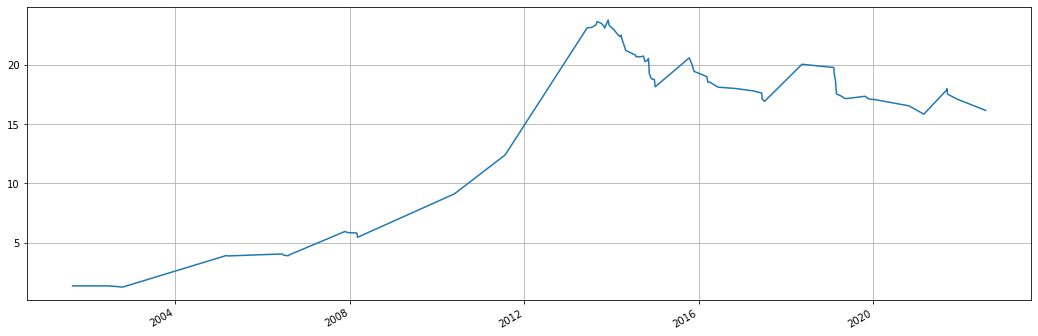

In [38]:
resultados_cumulativos.plot(figsize=(18, 6), grid=True)

In [39]:
100 * 15

1500

<AxesSubplot:>

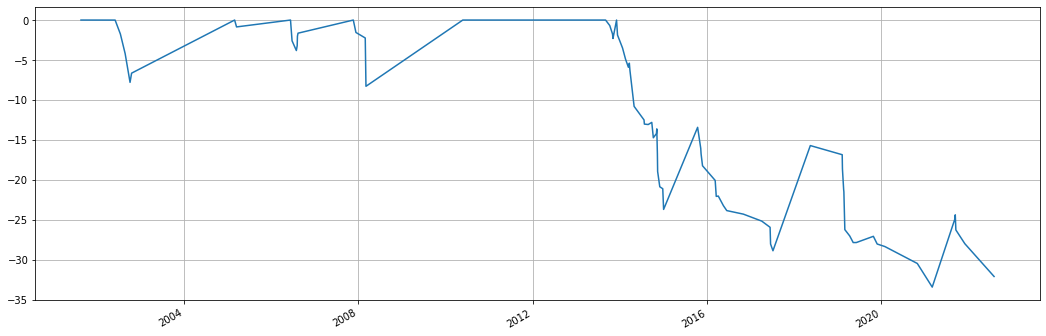

In [40]:
(((resultados_cumulativos / resultados_cumulativos.cummax()) - 1) * 100).plot(figsize=(18, 6), grid=True)

In [46]:
avaliar_retornos(pd.Series(resultado), resultados_cumulativos)

expectativa_matematica     5.51
taxa_de_acerto            31.25
drawdown máximo          -33.42
payoff                    11.11
numero de trades          80.00
retorno total             16.16
dtype: float64

In [ ]:
display(avaliar_retornos(retornos, retornos_compostos))

ax = retornos_compostos.plot(figsize=(9, 5), grid=True)
ax.set_xlabel('Anos');
ax.set_ylabel('Retorno (em %)')
ax.set_title(f'Retornos de {ativo} seguindo estratégia aleatória');

### Estratégia de volatilidade

In [74]:
historico_dos_precos['Distancia_Fechamento_MM200'] = historico_dos_precos['Close'] / historico_dos_precos['MM20']

In [75]:
treino = historico_dos_precos.head(historico_dos_precos.shape[0] // 2).index
teste = historico_dos_precos.tail(historico_dos_precos.shape[0] // 2).index

#### Avaliando no treino

<AxesSubplot:>

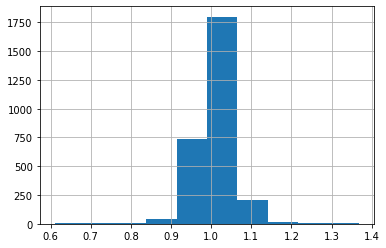

In [77]:
historico_dos_precos.loc[treino, 'Distancia_Fechamento_MM200'].hist()

In [84]:
historico_dos_precos['Regra de Compra'] = historico_dos_precos['Distancia_Fechamento_MM200'] < 0.9
historico_dos_precos['Regra de Venda'] = historico_dos_precos['Distancia_Fechamento_MM200'] > 1.1

resultado = aplicar_backtest(
    historico_dos_precos,
    historico_dos_precos['Regra de Compra'],
    historico_dos_precos['Regra de Venda']
)

resultados_cumulativos = (1 + pd.Series(resultado)).cumprod()

5692it [00:00, 8154.00it/s]


In [85]:
resultado

{Timestamp('2001-11-05 00:00:00'): 0.17021144409588285,
 Timestamp('2002-10-24 00:00:00'): 0.23380211419953345,
 Timestamp('2005-12-01 00:00:00'): -0.02655262102973832,
 Timestamp('2008-11-13 00:00:00'): -0.19565218519311067,
 Timestamp('2019-07-29 00:00:00'): 0.3412541390410606,
 Timestamp('2020-05-27 00:00:00'): -0.07379308240167026}

In [86]:
resultados_cumulativos

2001-11-05   1.17
2002-10-24   1.44
2005-12-01   1.41
2008-11-13   1.13
2019-07-29   1.52
2020-05-27   1.40
dtype: float64

<AxesSubplot:>

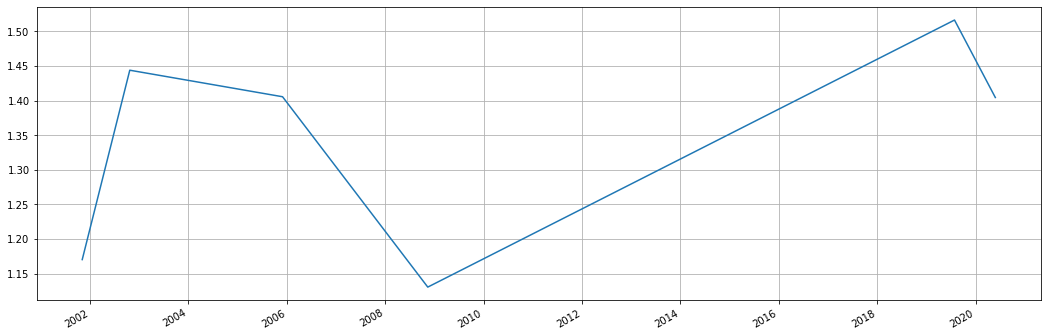

In [87]:
resultados_cumulativos.plot(figsize=(18, 6), grid=True)

<AxesSubplot:>

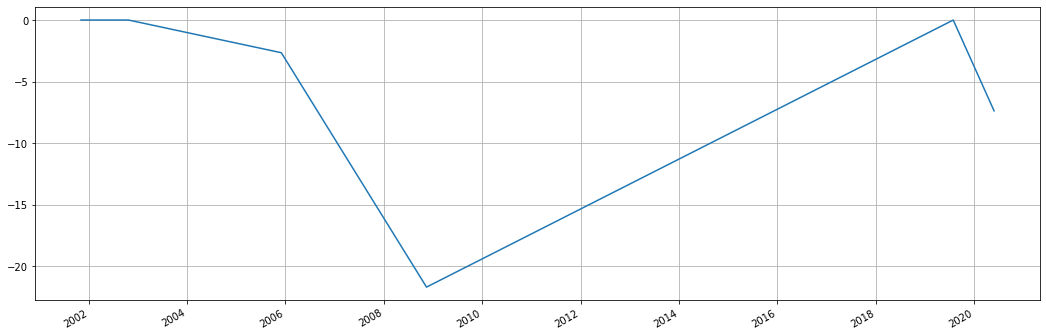

In [88]:
(((resultados_cumulativos / resultados_cumulativos.cummax()) - 1) * 100).plot(figsize=(18, 6), grid=True)

In [89]:
avaliar_retornos(pd.Series(resultado), resultados_cumulativos)

expectativa_matematica     7.49
taxa_de_acerto            50.00
drawdown máximo          -21.70
payoff                     2.52
numero de trades           6.00
retorno total              1.40
dtype: float64

#### Avaliando no teste

#### Avaliando em todo o período

### Estratégia com indicador

In [90]:
from ta.momentum import RSIIndicator

In [91]:
rsi = RSIIndicator(
    close=historico_dos_precos['Adj Close'],
    window=14,
    fillna=False
).rsi()

In [93]:
rsi

Date
2000-01-05     NaN
2000-01-06     NaN
2000-01-07     NaN
2000-01-10     NaN
2000-01-11     NaN
              ... 
2022-08-23   59.52
2022-08-24   65.13
2022-08-25   65.42
2022-08-26   61.34
2022-08-29   59.74
Name: rsi, Length: 5692, dtype: float64

#### Avaliando no treino

#### Avaliando no teste

#### Avaliando em todo o período